In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# @contextmanager
# def timer(title):
#     t0 = time.time()
#     yield
#     print("{} - done in {:.0f}s".format(title, time.time() - t0))

# # One-hot encoding for categorical columns with get_dummies
# def one_hot_encoder(df, nan_as_category = True):
#     original_columns = list(df.columns)
#     categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
#     df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
#     new_columns = [c for c in df.columns if c not in original_columns]
#     return df, new_columns

# # Preprocess application_train.csv and application_test.csv
# def application_train_test(num_rows = None, nan_as_category = False):
#     # Read data and merge
#     df = pd.read_csv('application_train.csv', nrows= num_rows)
# #     test_df = pd.read_csv('application_test.csv', nrows= num_rows)
# #     print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
# #     df = df.append(test_df).reset_index()
#     # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
#     df = df[df['CODE_GENDER'] != 'XNA']
    
#     # Categorical features with Binary encode (0 or 1; two categories)
#     for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
#         df[bin_feature], uniques = pd.factorize(df[bin_feature])
        
#     # Categorical features with One-Hot encode
#     df, cat_cols = one_hot_encoder(df, nan_as_category)
    
#     # NaN values for DAYS_EMPLOYED: 365.243 -> nan
#     df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
#     # Some simple new features (percentages)
#     df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
#     df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
#     df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
#     df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
#     df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
#     df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
# #     df=df.drop(['OWN_CAR_AGE','YEARS_BUILD_AVG','COMMONAREA_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_AVG','YEARS_BUILD_MODE','COMMONAREA_MODE','FLOORSMIN_MODE','LIVINGAPARTMENTS_MODE','NONLIVINGAPARTMENTS_MODE','YEARS_BUILD_MEDI','COMMONAREA_MEDI','FLOORSMIN_MEDI','LIVINGAPARTMENTS_MEDI','NONLIVINGAPARTMENTS_MEDI'],axis=1)
# #     df['NOT_SAME_REGION']=df[['REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']].sum(axis=1)
# #     df=df.drop(['REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY'],axis=1)
# #     del test_df
#     gc.collect()
#     return df

# # Preprocess bureau.csv and bureau_balance.csv
# def bureau_and_balance(num_rows = None, nan_as_category = True):
#     bureau = pd.read_csv('bureau.csv', nrows = num_rows)
#     bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
#     bb, bb_cat = one_hot_encoder(bb, nan_as_category)
#     bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
#     # Bureau balance: Perform aggregations and merge with bureau.csv
#     bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
#     for col in bb_cat:
#         bb_aggregations[col] = ['mean','sum']
#     bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
#     bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
#     bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
#     bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
#     del bb, bb_agg
#     gc.collect()
    
#     # Bureau and bureau_balance numeric features
#     num_aggregations = {
#         'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
#         'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean', 'var'],
#         'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean', 'var'],
#         'CREDIT_DAY_OVERDUE': ['min', 'max', 'mean', 'var'],
#         'AMT_CREDIT_MAX_OVERDUE': ['min', 'max', 'mean', 'var'],
#         'AMT_CREDIT_SUM': ['min', 'max', 'mean', 'var', 'sum'],
#         'AMT_CREDIT_SUM_DEBT': ['min', 'max', 'mean', 'var', 'sum'],
#         'AMT_CREDIT_SUM_OVERDUE': ['min', 'max', 'mean', 'var','sum'],
#         'AMT_CREDIT_SUM_LIMIT': ['min', 'max', 'mean', 'var', 'sum'],
#         'AMT_ANNUITY': ['min', 'max', 'mean', 'var'],
#         'CNT_CREDIT_PROLONG': ['min', 'max', 'mean', 'var','sum'],
#         'MONTHS_BALANCE_MIN': ['min'],
#         'MONTHS_BALANCE_MAX': ['max'],
#         'MONTHS_BALANCE_SIZE': ['mean','var', 'sum']
#     }
#     # Bureau and bureau_balance categorical features
#     cat_aggregations = {}
#     for cat in bureau_cat: cat_aggregations[cat] = ['mean','sum']
# #     for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
#     bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
#     bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
#     # Bureau: Active credits - using only numerical aggregations
#     active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
#     active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
#     active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
#     bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
#     del active, active_agg
#     gc.collect()
#     # Bureau: Closed credits - using only numerical aggregations
#     closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
#     closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
#     closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
#     bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
#     del closed, closed_agg, bureau
#     gc.collect()
#     return bureau_agg

# # Preprocess previous_applications.csv
# def previous_applications(num_rows = None, nan_as_category = True):
#     prev = pd.read_csv('previous_application.csv', nrows = num_rows)
#     prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
#     # Days 365.243 values -> nan
#     prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
#     # Add feature: value ask / value received percentage
#     prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
#     # Previous applications numeric features
#     num_aggregations = {
#         'AMT_ANNUITY': ['min', 'max', 'mean','var'],
#         'AMT_APPLICATION': ['min', 'max', 'mean','var'],
#         'AMT_CREDIT': ['min', 'max', 'mean','var'],
#         'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
#         'AMT_DOWN_PAYMENT': ['min', 'max', 'mean','var'],
#         'AMT_GOODS_PRICE': ['min', 'max', 'mean','var'],
#         'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean','var'],
#         'RATE_DOWN_PAYMENT': ['min', 'max', 'mean','var'],
#         'DAYS_DECISION': ['min', 'max', 'mean','var'],
#         'CNT_PAYMENT': ['min', 'max', 'mean','var', 'sum'],
#     }
#     # Previous applications categorical features
#     cat_aggregations = {}
#     for cat in cat_cols:
#         cat_aggregations[cat] = ['mean','sum']
    
#     prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
#     prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
#     # Previous Applications: Approved Applications - only numerical features
#     approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
#     approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
#     approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
#     prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
#     # Previous Applications: Refused Applications - only numerical features
#     refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
#     refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
#     refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
#     prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
#     del refused, refused_agg, approved, approved_agg, prev
#     gc.collect()
#     return prev_agg

# # Preprocess POS_CASH_balance.csv
# def pos_cash(num_rows = None, nan_as_category = True):
#     pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
#     pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
#     # Features
#     aggregations = {
#         'MONTHS_BALANCE': ['min','max', 'mean', 'size'],
#         'SK_DPD': ['min','max', 'mean'],
#         'SK_DPD_DEF': ['min','max', 'mean']
#     }
#     for cat in cat_cols:
#         aggregations[cat] = ['mean','sum']
    
#     pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
#     pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
#     # Count pos cash accounts
#     pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
#     del pos
#     gc.collect()
#     return pos_agg
    
# # Preprocess installments_payments.csv
# def installments_payments(num_rows = None, nan_as_category = True):
#     ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
#     ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
#     # Percentage and difference paid in each installment (amount paid and installment value)
#     ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
#     ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
#     # Days past due and days before due (no negative values)
#     ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
#     ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
#     ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
#     ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
#     # Features: Perform aggregations
#     aggregations = {
#         'NUM_INSTALMENT_VERSION': ['nunique'],
#         'DPD': ['min','max', 'mean', 'sum'],
#         'DBD': ['min','max', 'mean', 'sum'],
#         'PAYMENT_PERC': ['min','max', 'mean', 'var'],
#         'PAYMENT_DIFF': ['min','max', 'mean', 'sum', 'var'],
#         'AMT_INSTALMENT': ['min','max', 'mean', 'sum'],
#         'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
#         'DAYS_ENTRY_PAYMENT': ['min','max', 'mean', 'sum']   
#     }
#     for cat in cat_cols:
#         aggregations[cat] = ['mean','sum']
#     ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
#     ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
#     # Count installments accounts
#     ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
#     del ins
#     gc.collect()
#     return ins_agg

# # Preprocess credit_card_balance.csv
# def credit_card_balance(num_rows = None, nan_as_category = True):
#     cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
#     cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
#     # General aggregations
#     cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
#     cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
#     cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
#     # Count credit card lines
#     cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
#     del cc
#     gc.collect()
#     return cc_agg

# # # LightGBM GBDT with KFold or Stratified KFold
# # # Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
# # def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
# #     # Divide in training/validation and test data
# #     train_df = df[df['TARGET'].notnull()]
# #     test_df = df[df['TARGET'].isnull()]
# #     print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
# #     del df
# #     gc.collect()
# #     # Cross validation model
# #     if stratified:
# #         folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
# #     else:
# #         folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
# #     # Create arrays and dataframes to store results
# #     oof_preds = np.zeros(train_df.shape[0])
# #     sub_preds = np.zeros(test_df.shape[0])
# #     feature_importance_df = pd.DataFrame()
# #     feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
# #     for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
# #         train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
# #         valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

# #         # LightGBM parameters found by Bayesian optimization
# #         clf = LGBMClassifier(
# #             nthread=4,
# #             n_estimators=10000,
# #             learning_rate=0.02,
# #             num_leaves=34,
# #             colsample_bytree=0.9497036,
# #             subsample=0.8715623,
# #             max_depth=8,
# #             reg_alpha=0.041545473,
# #             reg_lambda=0.0735294,
# #             min_split_gain=0.0222415,
# #             min_child_weight=39.3259775,
# #             silent=-1,
# #             verbose=-1, )

# #         clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
# #             eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

# #         oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
# #         sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

# #         fold_importance_df = pd.DataFrame()
# #         fold_importance_df["feature"] = feats
# #         fold_importance_df["importance"] = clf.feature_importances_
# #         fold_importance_df["fold"] = n_fold + 1
# #         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
# #         print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
# #         del clf, train_x, train_y, valid_x, valid_y
# #         gc.collect()

# #     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
# #     # Write submission file and plot feature importance
# #     if not debug:
# #         test_df['TARGET'] = sub_preds
# #         test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
# #     display_importances(feature_importance_df)
# #     return feature_importance_df

# # Display/plot feature importance
# def display_importances(feature_importance_df_):
#     cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
#     best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
#     plt.figure(figsize=(8, 10))
#     sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
#     plt.title('LightGBM Features (avg over folds)')
#     plt.tight_layout()
#     plt.savefig('lgbm_importances01.png')


# def compiler(debug = False):
#     num_rows = 10000 if debug else None
#     df = application_train_test(num_rows)
#     with timer("Process bureau and bureau_balance"):
#         bureau = bureau_and_balance(num_rows)
#         print("Bureau df shape:", bureau.shape)
#         df = df.join(bureau, how='left', on='SK_ID_CURR')
#         del bureau
#         gc.collect()
#     with timer("Process previous_applications"):
#         prev = previous_applications(num_rows)
#         print("Previous applications df shape:", prev.shape)
#         df = df.join(prev, how='left', on='SK_ID_CURR')
#         del prev
#         gc.collect()
#     with timer("Process POS-CASH balance"):
#         pos = pos_cash(num_rows)
#         print("Pos-cash balance df shape:", pos.shape)
#         df = df.join(pos, how='left', on='SK_ID_CURR')
#         del pos
#         gc.collect()
#     with timer("Process installments payments"):
#         ins = installments_payments(num_rows)
#         print("Installments payments df shape:", ins.shape)
#         df = df.join(ins, how='left', on='SK_ID_CURR')
#         del ins
#         gc.collect()
#     with timer("Process credit card balance"):
#         cc = credit_card_balance(num_rows)
#         print("Credit card balance df shape:", cc.shape)
#         df = df.join(cc, how='left', on='SK_ID_CURR')
#         del cc
#         gc.collect()
#     return df
# #     with timer("Run LightGBM with kfold"):
# #         feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

# # if __name__ == "__main__":
# #     submission_file_name = "submission_kernel02.csv"
# #     with timer("Full model run"):
# #         main()

# df = compiler(debug = False)

In [6]:
# df
#1106 variables

In [79]:
# df.to_csv('augmented_home_credit_data.csv',index = False)
df = pd.read_csv('augmented_home_credit_data.csv')

In [35]:
df.columns.tolist()[:248]
df_app = df.iloc[:,0:248] # Remember that Python does not slice inclusive of the ending index.
# df_app

In [37]:
len(df_app.columns.tolist())

248

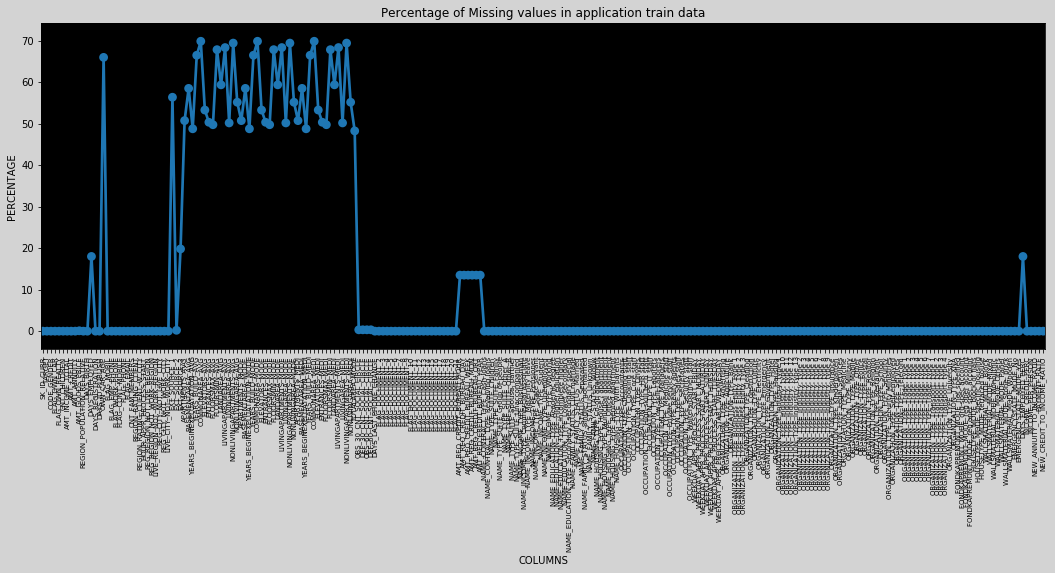

In [38]:
fig = plt.figure(figsize=(18,6))
missing = pd.DataFrame((df_app.isnull().sum())*100/df_app.shape[0]).reset_index()
# miss_test = pd.DataFrame((application_test.isnull().sum())*100/application_test.shape[0]).reset_index()
# missing["type"] = "train"
# miss_test["type"]  =  "test"
# missing = pd.concat([miss_train,miss_test],axis=0)
ax = sns.pointplot("index",0,data=missing)
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values in application train data")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
ax.set_facecolor("k")
fig.set_facecolor("lightgrey")


In [80]:
# Train missing values (in percent)
train_missing = (df.isnull().sum() / len(df)).sort_values(ascending = False)

In [81]:
# train_missing.index[train_missing > 0.75]

In [82]:
# Identify missing values above threshold
for n in range(0,100,5):
    train_missing_ = train_missing.index[train_missing > n/100]
    print('There are %d columns with more than %s%% missing values' % (len(train_missing_),n))

There are 924 columns with more than 0% missing values
There are 912 columns with more than 5% missing values
There are 482 columns with more than 10% missing values
There are 388 columns with more than 15% missing values
There are 379 columns with more than 20% missing values
There are 372 columns with more than 25% missing values
There are 307 columns with more than 30% missing values
There are 292 columns with more than 35% missing values
There are 285 columns with more than 40% missing values
There are 275 columns with more than 45% missing values
There are 265 columns with more than 50% missing values
There are 242 columns with more than 55% missing values
There are 229 columns with more than 60% missing values
There are 225 columns with more than 65% missing values
There are 189 columns with more than 70% missing values
There are 59 columns with more than 75% missing values
There are 51 columns with more than 80% missing values
There are 11 columns with more than 85% missing valu

In [84]:
missing = train_missing.index[train_missing > 0.75]
# print (missing.values.tolist())
train = df.drop(columns = missing.values.tolist())
# train = df.drop(missing.values.tolist(), axis=1)
print('Training set full shape: ', train.shape)

Training set full shape:  (307507, 1047)


In [44]:
# train.to_csv('home_credit_missing_.70.csv')

In [72]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent*100], axis=1, keys=['Total', 'Percent'])

In [73]:
# missing_data

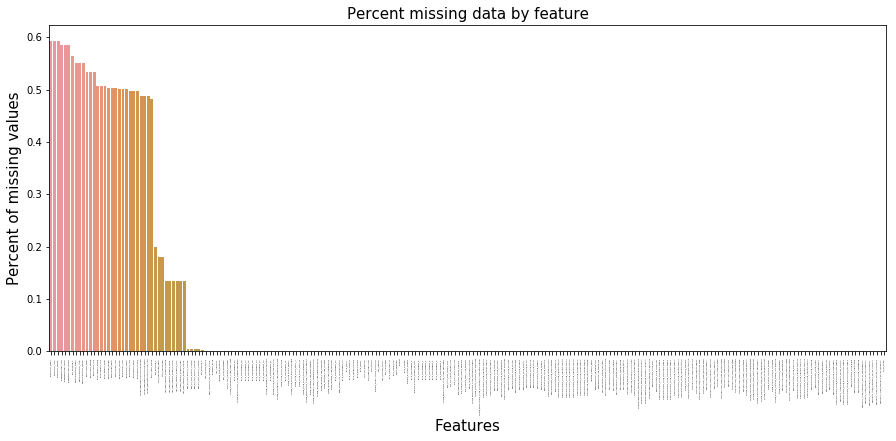

In [48]:
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.xticks(fontsize = 2)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

In [94]:
#for missing data handling
# https://www.kaggle.com/dansbecker/handling-missing-values

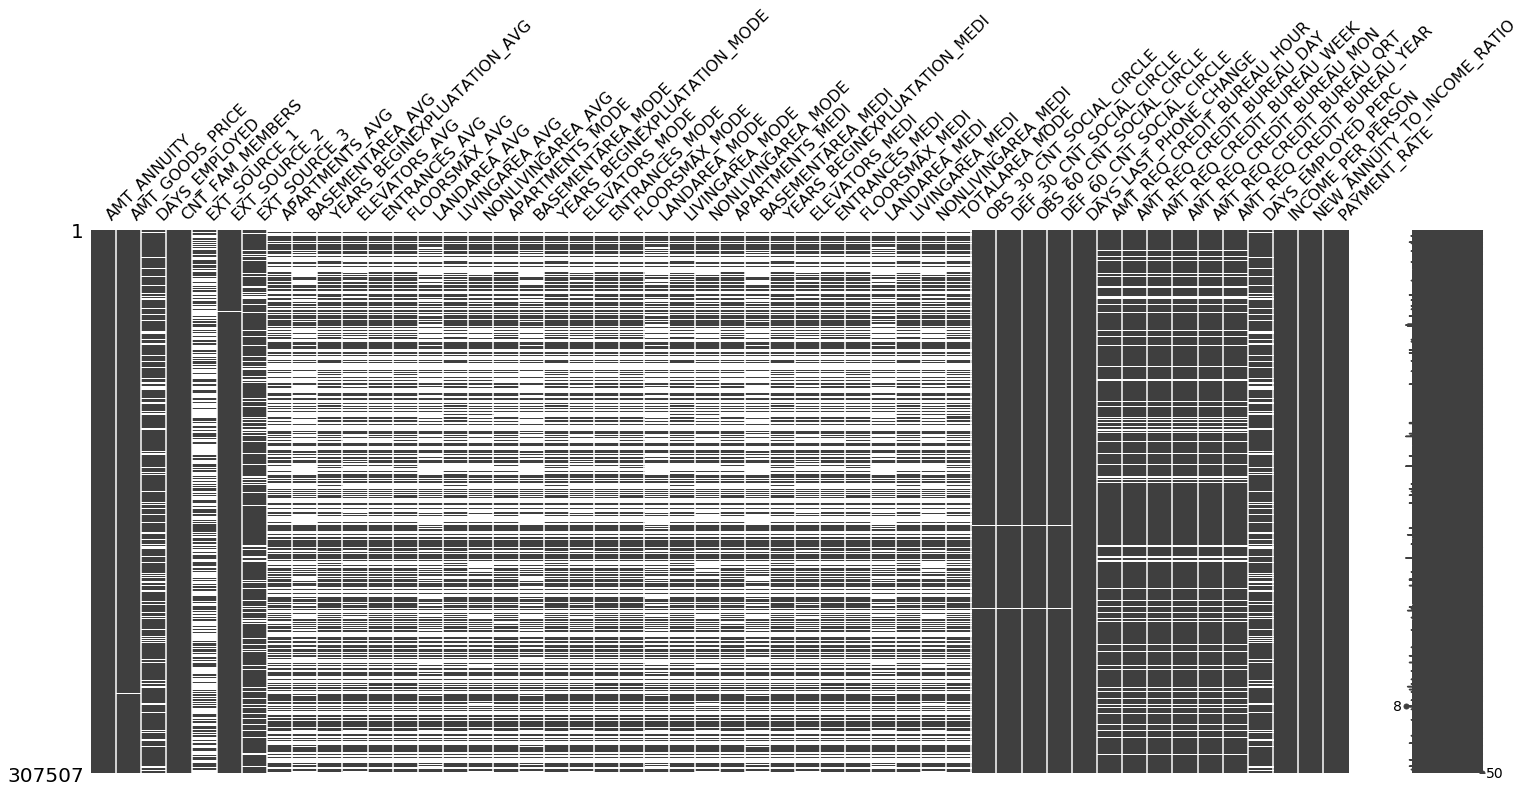

In [45]:
import missingno as msno
missingdata_df = train.columns[train.isnull().any()].tolist()
msno.matrix(train[missingdata_df])


### Replace with Mean, Median, Mode

In [46]:
# df_filled_mean = train.fillna(train.mean())
# df_filled_median = train.fillna(train.median())

### Replace using kNN

-> computationally expensive

-> take random sample

In [88]:
from fancyimpute import KNN 
#We use the train dataframe from Titanic dataset
#fancy impute removes column names.
t = train.sample(3000)
train_cols = list(t)
# Use 5 nearest rows which have a feature to fill in each row's
# missing features
train_knn = pd.DataFrame(KNN(k=2).complete(t))
train_knn.columns = train_cols


Imputing row 1/3000 with 748 missing, elapsed time: 45.628
Imputing row 101/3000 with 408 missing, elapsed time: 46.140
Imputing row 201/3000 with 831 missing, elapsed time: 46.666
Imputing row 301/3000 with 195 missing, elapsed time: 47.170
Imputing row 401/3000 with 170 missing, elapsed time: 47.664
Imputing row 501/3000 with 215 missing, elapsed time: 48.190
Imputing row 601/3000 with 360 missing, elapsed time: 48.718
Imputing row 701/3000 with 345 missing, elapsed time: 49.238
Imputing row 801/3000 with 183 missing, elapsed time: 49.750
Imputing row 901/3000 with 719 missing, elapsed time: 50.213
Imputing row 1001/3000 with 168 missing, elapsed time: 50.838
Imputing row 1101/3000 with 174 missing, elapsed time: 51.392
Imputing row 1201/3000 with 258 missing, elapsed time: 51.919
Imputing row 1301/3000 with 410 missing, elapsed time: 52.518
Imputing row 1401/3000 with 180 missing, elapsed time: 53.172
Imputing row 1501/3000 with 194 missing, elapsed time: 53.842
Imputing row 1601/30

In [90]:
train
train_knn.isnull().sum().sort_values(ascending=False)
train_knn.shape

(3000, 1047)